### Panchy et al. 2022

In [1]:
import os
import csv
import numpy as np
import pandas as pd

import openpyxl
import phate
from scipy.sparse import csr_matrix, csc_matrix # tocsr command import
from scipy import io

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import scanpy as sc

# Scanpy params
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, figsize=[5,5])
plt.rcParams['figure.figsize']=(5,5)
plt.ioff();

In [2]:
currDir = os.getcwd()

In [3]:
currDir

'/Users/meilumcd/Desktop/EMT-in-cancer/6-Panchy/Code'

directory paths & file names

In [4]:
### DIRECTORY PATHS ###
# Start in "EMT-in-cancer/6-Panchy/Code" folder

# Main dataset directory
mainDir = os.path.dirname(os.path.dirname(currDir))

# Data directories
dataDir = os.path.dirname(mainDir)+"/EMT-in-cancer-datafiles/6-Panchy/_h5ad/"
rawDir = os.path.dirname(mainDir)+"/EMT-in-cancer-datafiles/6-Panchy/_rawData/"

# Figure directory
figDir = os.path.dirname(currDir)+"/Figures/"
sc.settings.figdir = figDir

# Data summaries/output directory
dataSumDir = os.path.dirname(currDir)+"/DataSummaries/"

# EMT marker directory
emtMarkerDir = mainDir+"/Cross-Dataset Comparisons/Markers/"

In [69]:
### FILE PATHS ###

# Files: Raw data names from GEO
raw_data = "GSM6593509_matrix.mtx"
raw_genes = "GSM6593509_genes.tsv"
raw_cells = "GSM6593509_barcodes.tsv.gz"
raw_metadata = "GSM6593509_Concentration_GBC_annotation_Samples.csv.gz"

# Files: cell cycle markers
cellCycle_g1S_csv = "Cell Cycle Markers - G1,S Genes.csv"
cellCycle_g2M_csv = "Cell Cycle Markers - G2,M Genes.csv"

# Files: EMT markers
msigdbMarkersCsv = "Markers - MSigDB.csv"
panglaoMarkersCsv = "Markers - PanglaoDB, Epithelial.csv"
empCookMarkersCsv = "Markers - EMP Cook 2021.csv"

### Part 1: IMPORT DATA, FILTERING, AND NORMALIZATION

In [6]:
# Import genes, cells, metadata

genes = pd.read_csv(rawDir+raw_genes, header=None)
# Crop the Ensembl gene IDs from the gene name
genes = genes[0].str.split('\t').str[1].to_list()

cells = pd.read_csv(rawDir+raw_cells, header=None)[0].to_list()
metadata = pd.read_csv(rawDir+raw_metadata, index_col=0)

In [7]:
# Import data files

# Importing from mtx takes a while; re-saved it as h5ad
# adata_raw = sc.read_mtx(rawDir+raw_data).T
# adata_raw.write(dataDir+"0-rawMtx.h5ad")
adata = sc.read_h5ad(dataDir+"0-rawMtx.h5ad")
adata.var.index = genes
adata.var_names_make_unique()
adata.var_names = adata.var_names.str.upper() # Gene names as all uppercase
adata.obs.index = cells
# adata.X = adata.X.tocsr() # Is this necessary? type() already says csr matrix

In [8]:
# Filter for only cells that have barcodes
# NOTE: these are cells that are filtered by the orig authors!
adata = adata[adata.obs.index.isin(metadata.index)].copy()

# Add the barcodes
adata.obs['Dose Barcode'] = metadata['Values']
# Annotate dosage info
labelDict = {1: 0,
             2: 12.5,
             3: 25,
             4: 50,
             8: 100,
             9: 200,
             12: 400,
             13: 800}
adata.obs["Dose ug"] = adata.obs["Dose Barcode"].replace(to_replace=labelDict)

In [9]:
# Remove Dose 0 cells
adata = adata[adata.obs["Dose ug"] != 0]

FILTERING

In [10]:
# Remove ERCC genes
ercc_genes = adata.var_names.str.startswith('ERCC')
adata = adata[:, ercc_genes==False].copy()

# Filter for minimum cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

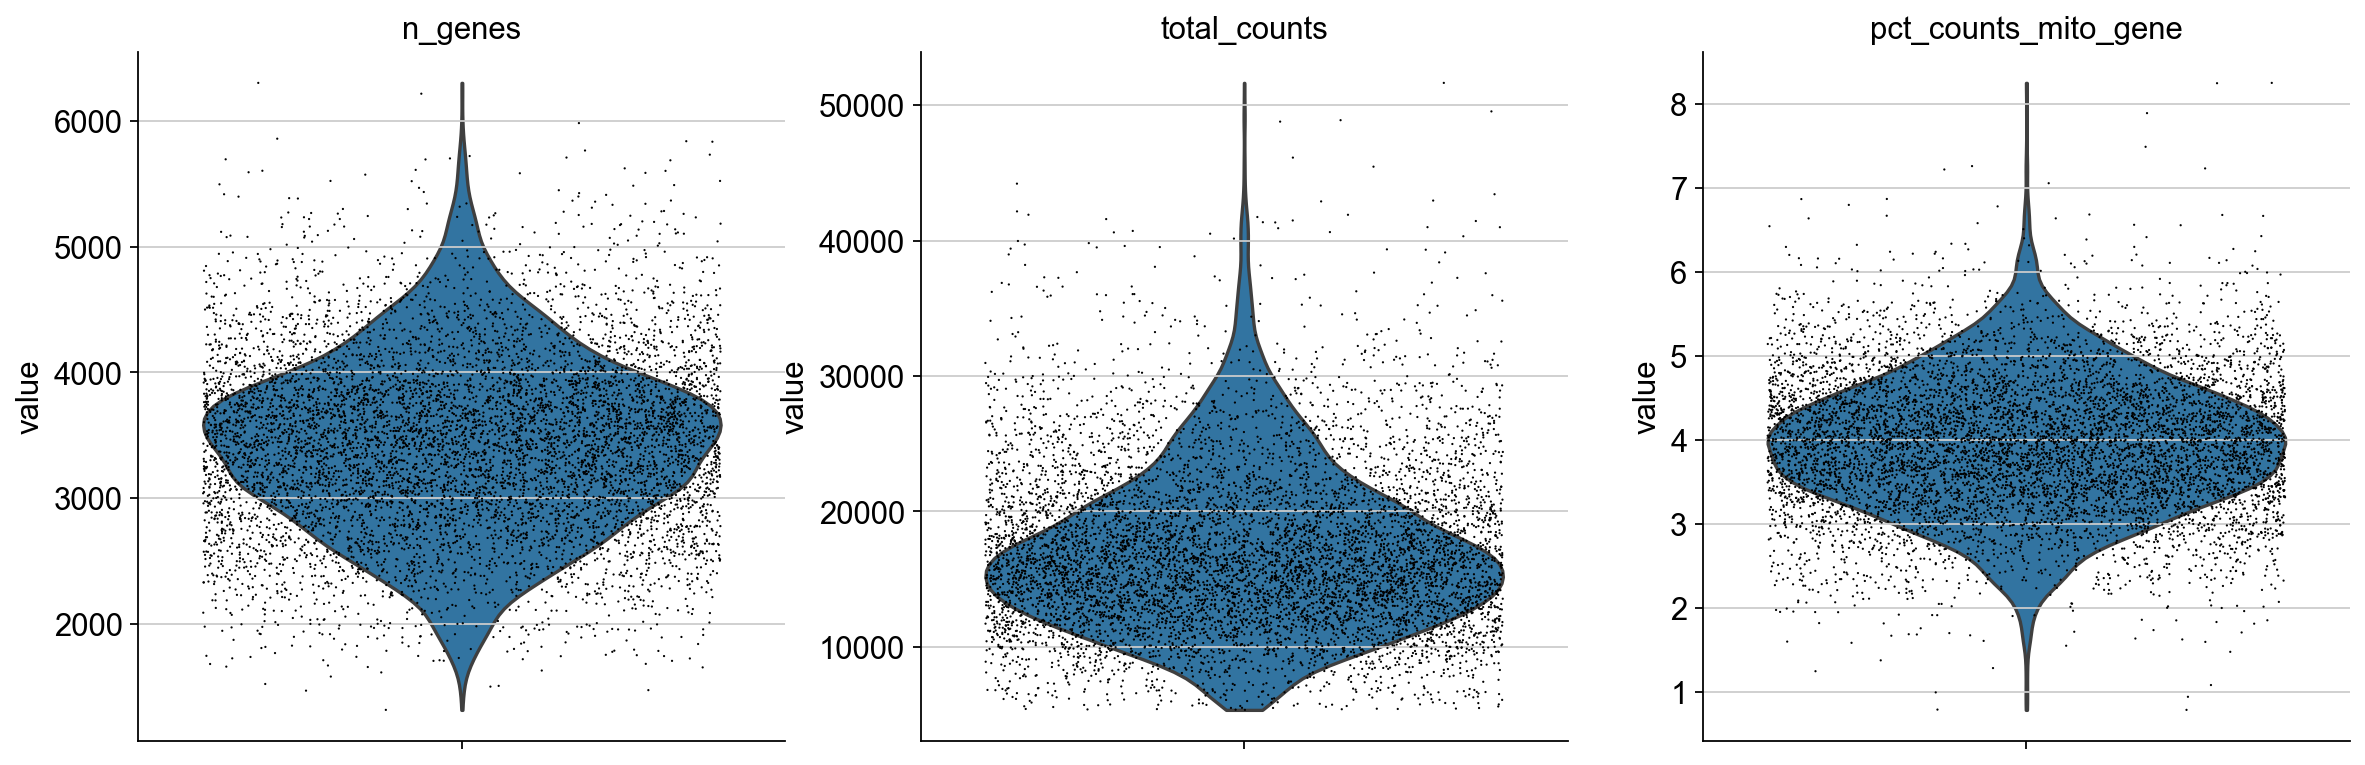

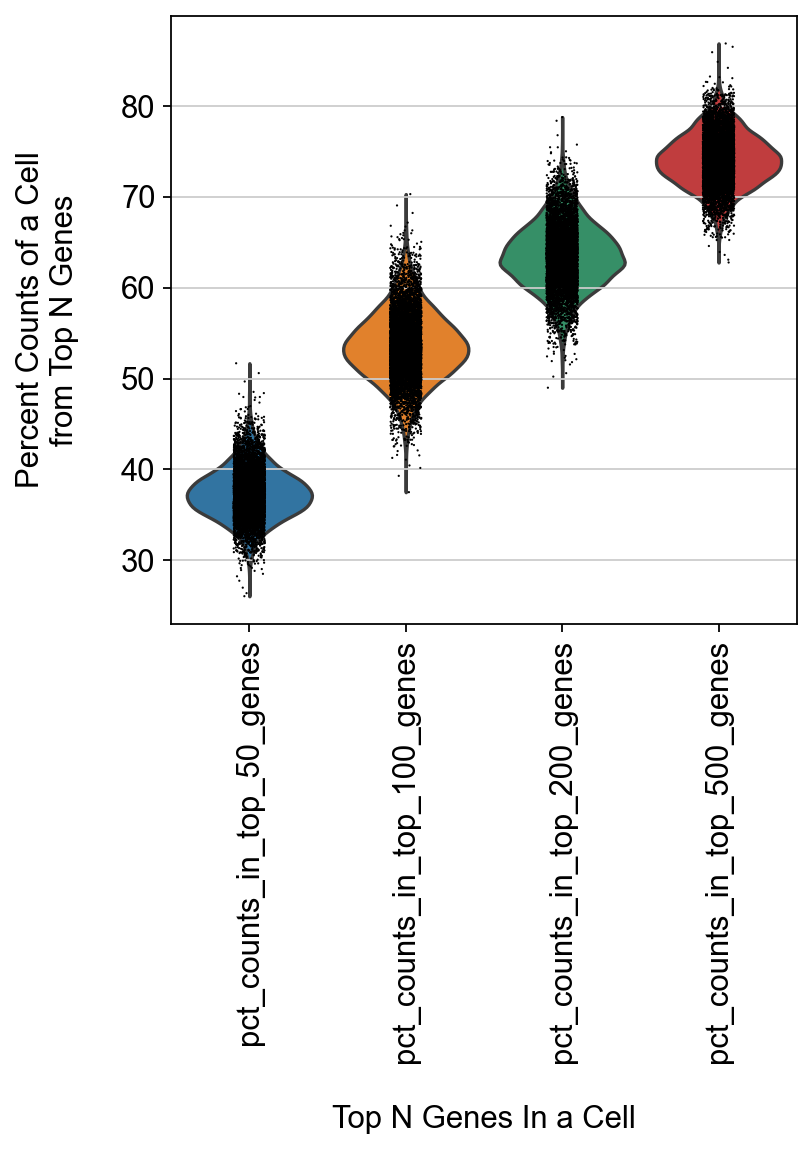

In [11]:
# Identify mitochondrial genes
adata.var['mito_gene'] = adata.var.index.str.startswith(('MT-', 'MTRNR'))

# Run QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mito_gene'], log1p=False, inplace=True)

# Basic metrics
sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mito_gene'], multi_panel=True, jitter=0.4, save=" - n_genes, n_counts, perc_mito.png")

# Top N genes constituting what fraction of total counts, per cell
sc.pl.violin(adata, ['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'],
             rotation=90, ylabel='Percent Counts of a Cell\nfrom Top N Genes\n', xlabel='\nTop N Genes In a Cell',
             save=" - pct_counts_in_top_n_genes.png")
# Deleting this obs to remove clutter
del adata.obs['pct_counts_in_top_50_genes'], adata.obs['pct_counts_in_top_100_genes'], adata.obs['pct_counts_in_top_200_genes'], adata.obs['pct_counts_in_top_500_genes']

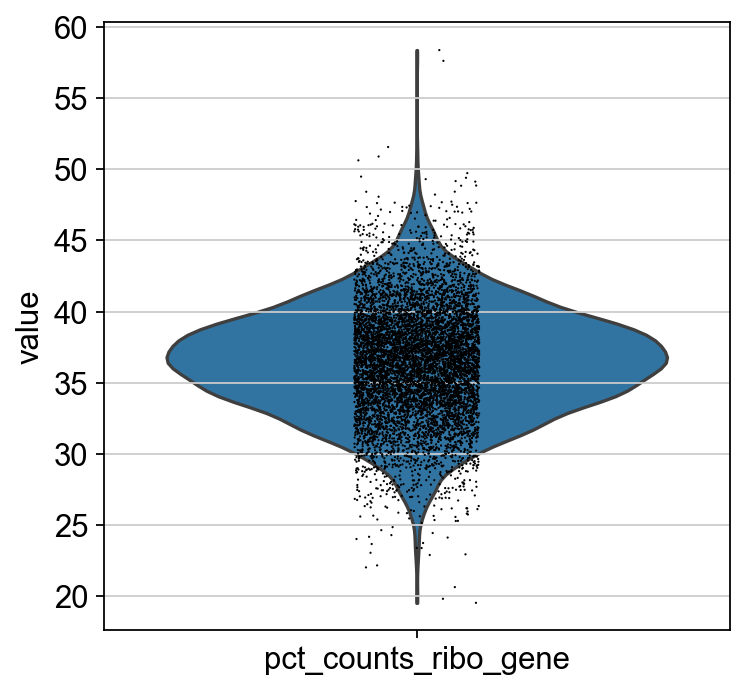

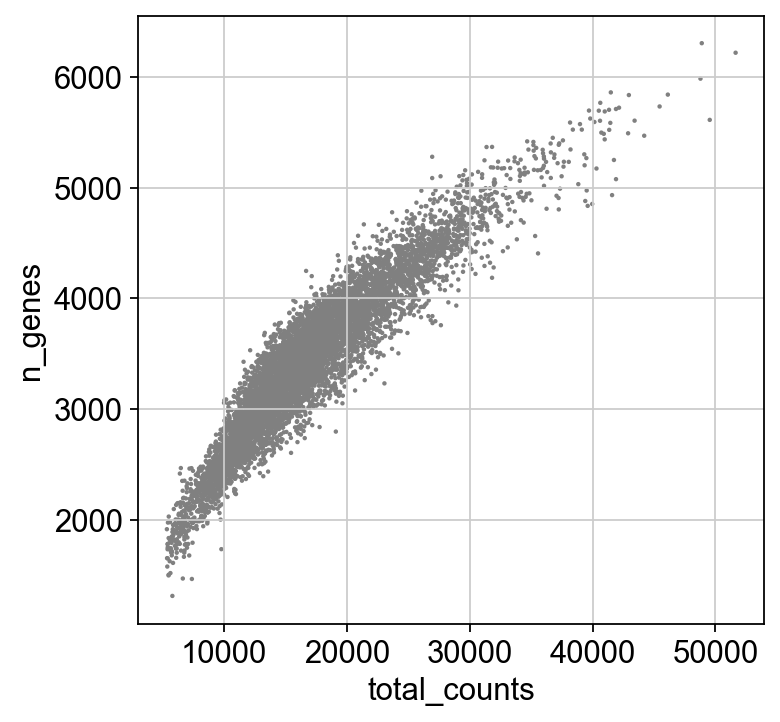

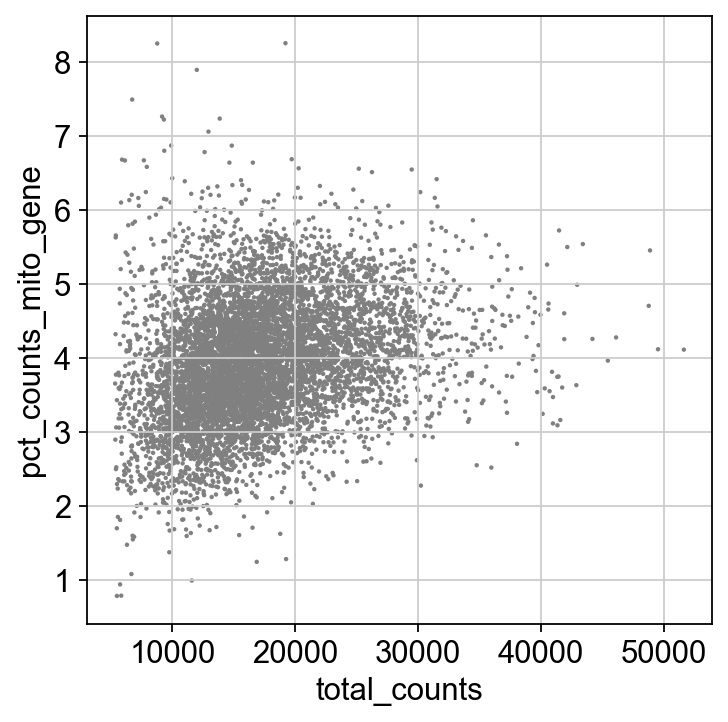

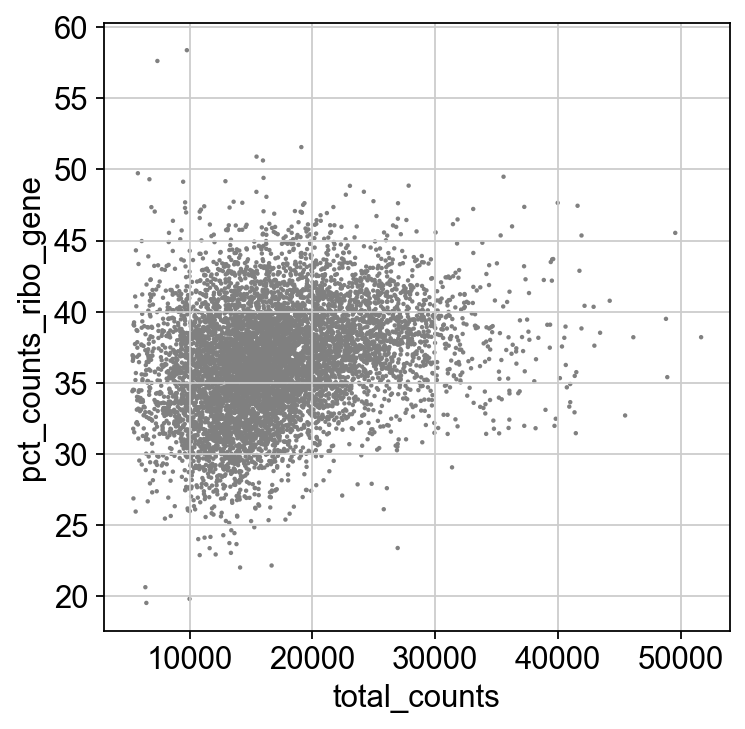

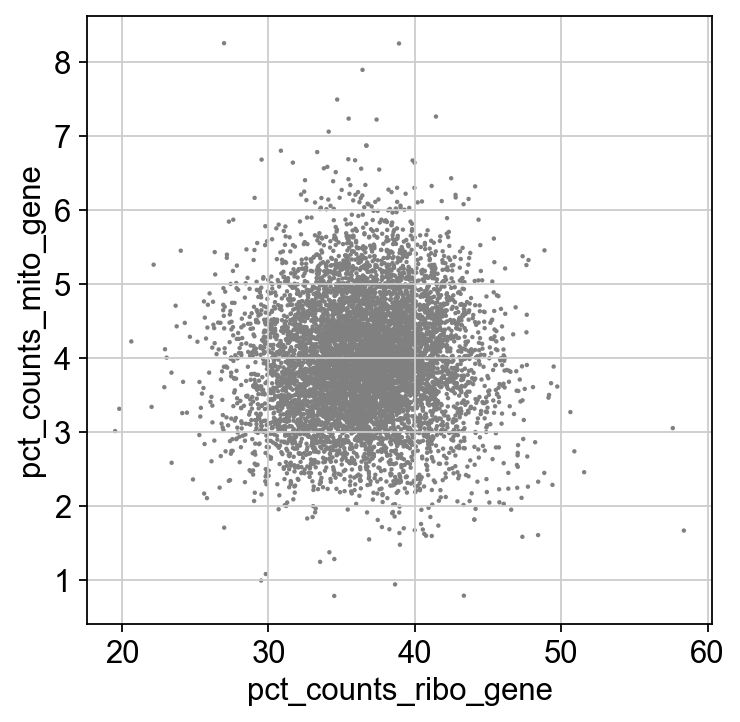

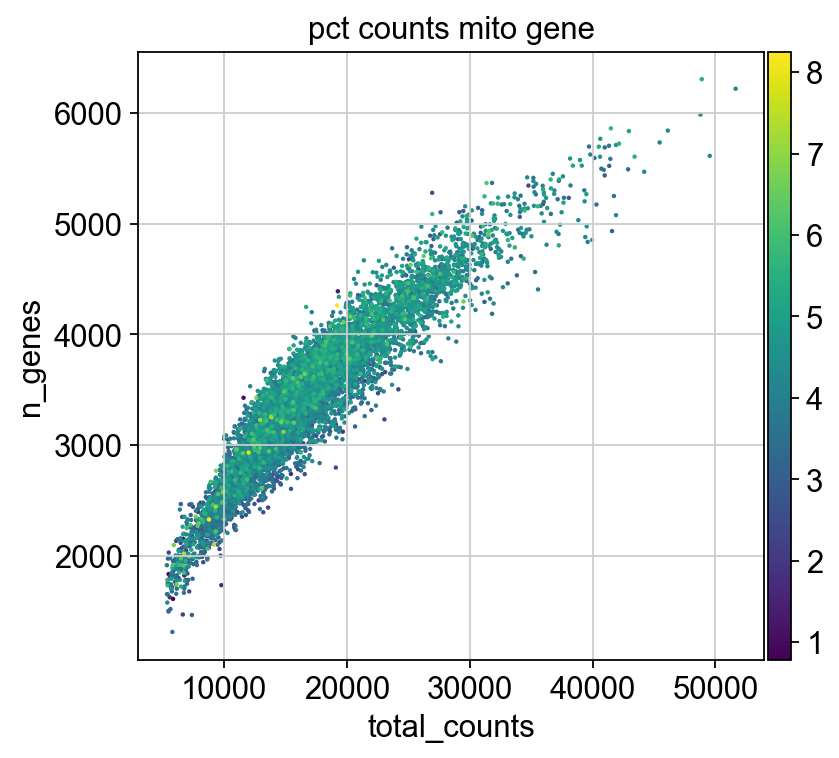

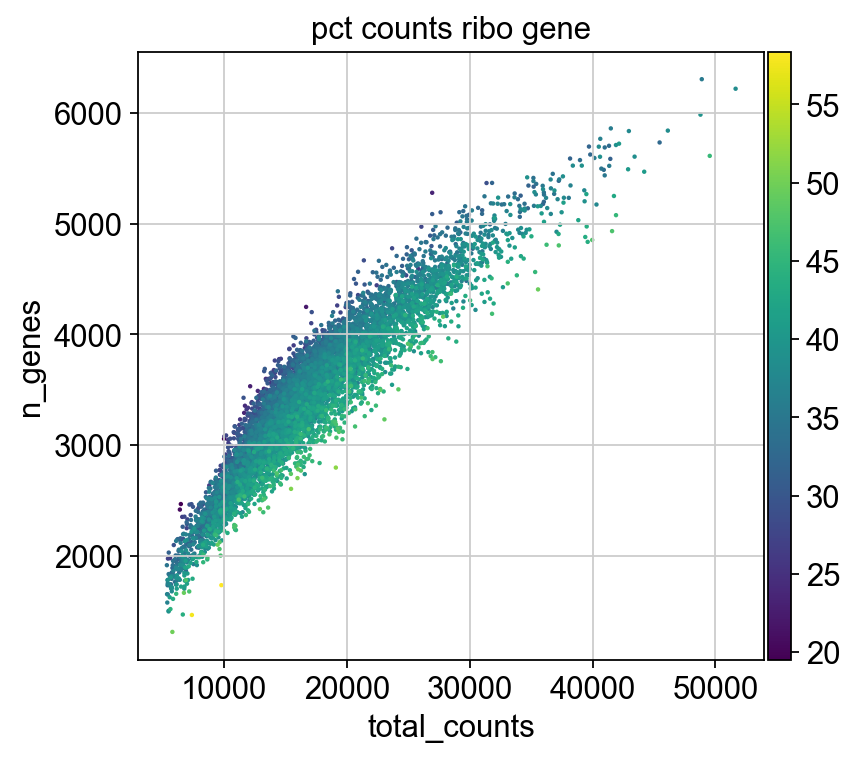

In [12]:
# Identify ribosomal genes
ribo_genes = adata.var.index.str.startswith(('RPL','RPS'))
adata.obs["pct_counts_ribo_gene"] = 100*np.sum(adata[:, ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)
sc.pl.violin(adata, ["pct_counts_ribo_gene"], save=" - pct_counts_ribo_gene.png")

# Gene metric scatterplots
sc.pl.scatter(adata, x='total_counts', y='n_genes')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mito_gene')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo_gene')
sc.pl.scatter(adata, x='pct_counts_ribo_gene', y='pct_counts_mito_gene')
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='pct_counts_mito_gene', save=" - n_genes vs total_counts.png")
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='pct_counts_ribo_gene')

In [13]:
# FILTERING

# Remove total_count outliers
adata = adata[adata.obs["total_counts"] < 35000,:].copy()

# Remove mito genes
adata = adata[:, adata.var.mito_gene==False].copy() # Remove mito genes
# Remove high mito cells
adata = adata[adata.obs.pct_counts_mito_gene < 7, :].copy()

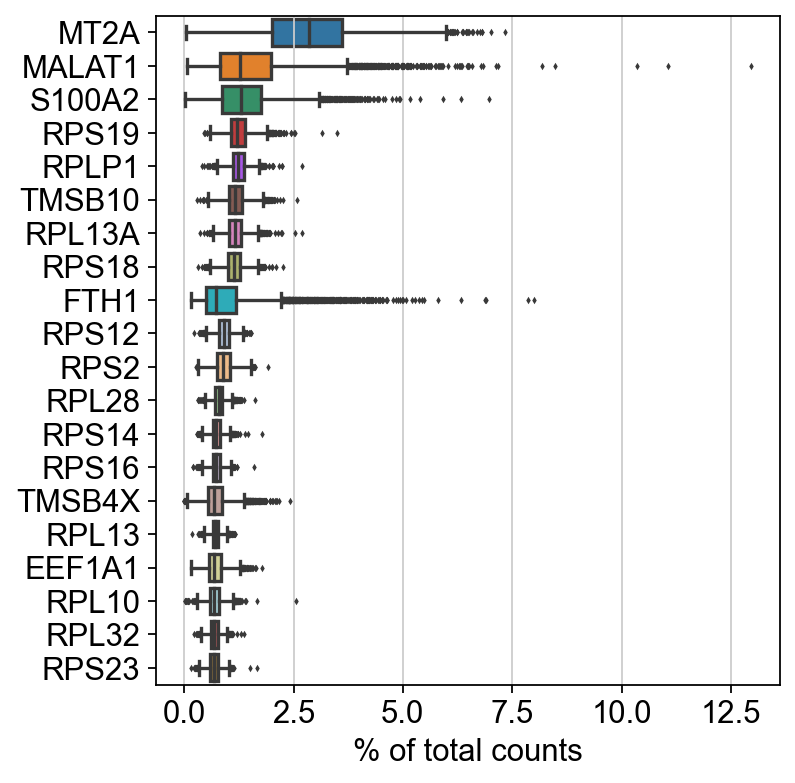

In [14]:
# Genes with largest proportions, after filtering
sc.pl.highest_expr_genes(adata, n_top=20, save=" - genes w highest expression.png")

# Save filtered genes
adata.write(dataDir+"1-Filtered_and_Normalized_allGenes.h5ad")

In [15]:
# Run scrublet on the author-filtered data just in case
sc.external.pp.scrublet(adata)

/Users/meilumcd/opt/anaconda3/envs/24.04-scanpy-phate/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 17.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.9%


In [16]:
# Import cell cycle genes

# G1/S Genes
cellCycle_g1S_genes = []
with open(emtMarkerDir+cellCycle_g1S_csv) as inputFile:
    reader = csv.reader(inputFile)
    # no header
    for row in reader:
        if row[0] in adata.var_names:
            cellCycle_g1S_genes.append(row[0])

# G2/M Genes
cellCycle_g2M_genes = []
with open(emtMarkerDir+cellCycle_g2M_csv) as inputFile:
    reader = csv.reader(inputFile)
    # no header
    for row in reader:
        if row[0] in adata.var_names:
            cellCycle_g2M_genes.append(row[0])

NORMALIZATION

In [17]:
# Total-count normalize to 10,000 counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)
adata.raw = adata
# Save normalized data
adata.write(dataDir+"1-Filtered_and_Normalized_allGenes.h5ad")

# Log of genes
sc.pp.log1p(adata)
# Set raw - later scanpy analysis uses this
adata.raw = adata
# Add cell cycle score
adata.X = adata.X.astype('<f8')
sc.tl.score_genes_cell_cycle(adata, s_genes=cellCycle_g1S_genes, g2m_genes=cellCycle_g2M_genes, use_raw=False)
adata.X = adata.X.astype('<f4')


/Users/meilumcd/opt/anaconda3/envs/24.04-scanpy-phate/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/meilumcd/opt/anaconda3/envs/24.04-scanpy-phate/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [18]:
# Highly variable genes (note: expects log data)
sc.pp.highly_variable_genes(adata)
adataHiVar = adata[:, adata.var.highly_variable].copy()

# Regress out effects of total counts per cell and percent mito and cell cycle
sc.pp.regress_out(adataHiVar, ['total_counts', 'pct_counts_mito_gene', 'G2M_score','S_score'])

# Scale to unit variance
sc.pp.scale(adataHiVar, max_value=10)

# Save filtered and normalized data
adata.write(dataDir+"/1-Filtered_and_Normalized_hiVarGenes.h5ad")

### Part 2: CLUSTERING AND DE GENES

In [19]:
%matplotlib inline
sc.settings.set_figure_params(dpi=80, figsize=[5,5])
plt.rcParams['figure.figsize']=(5,5)

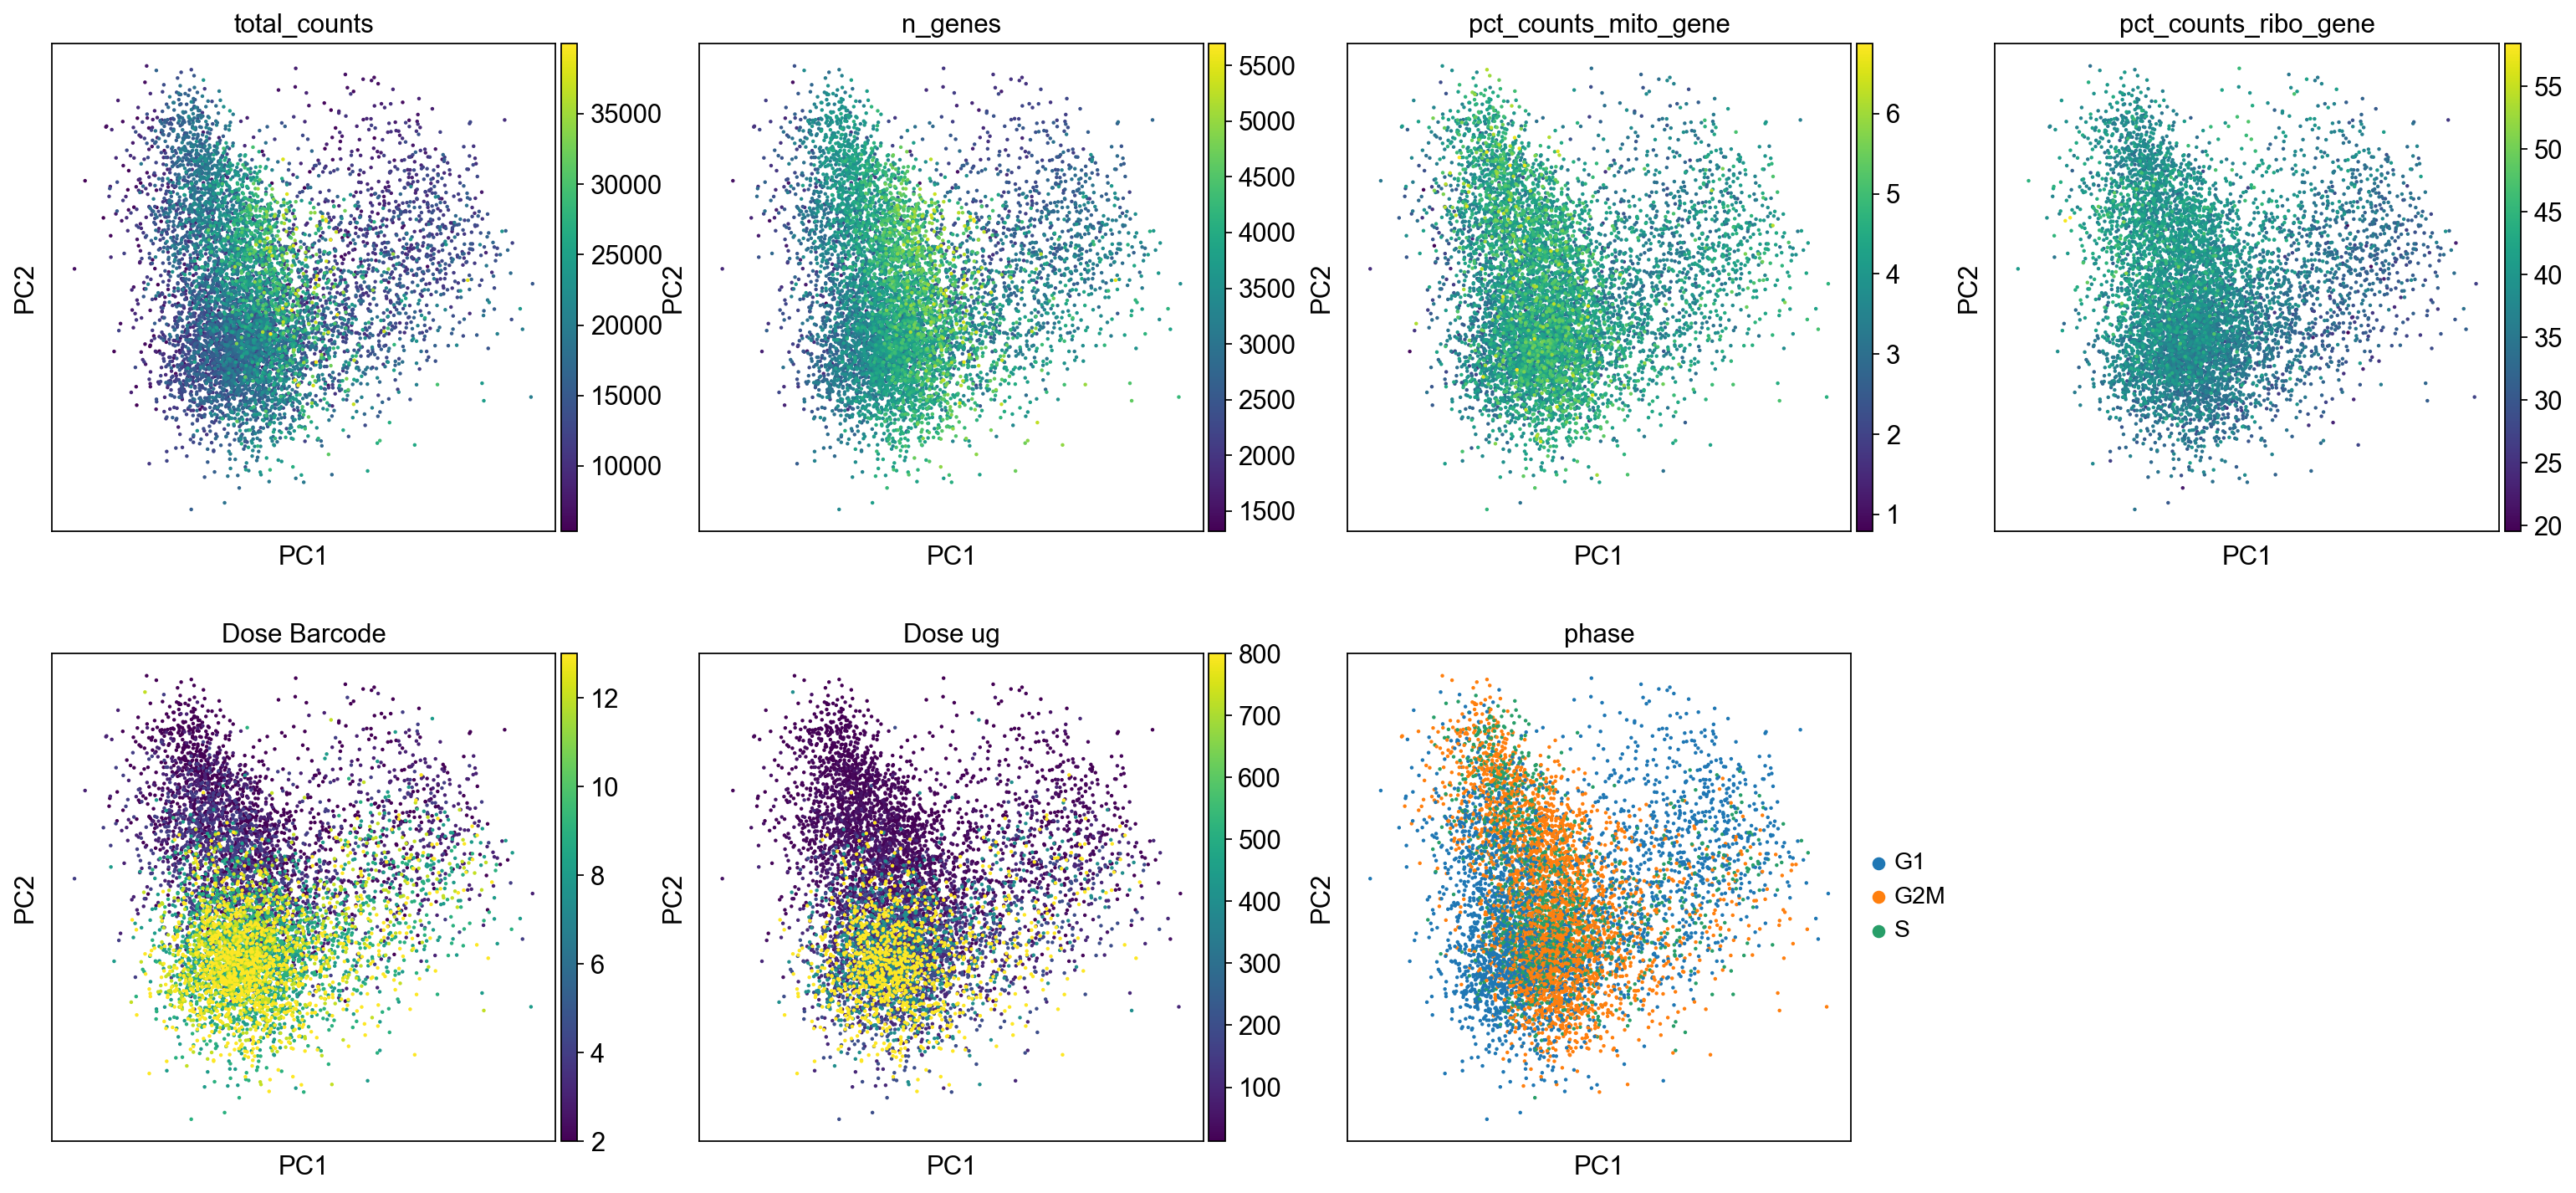

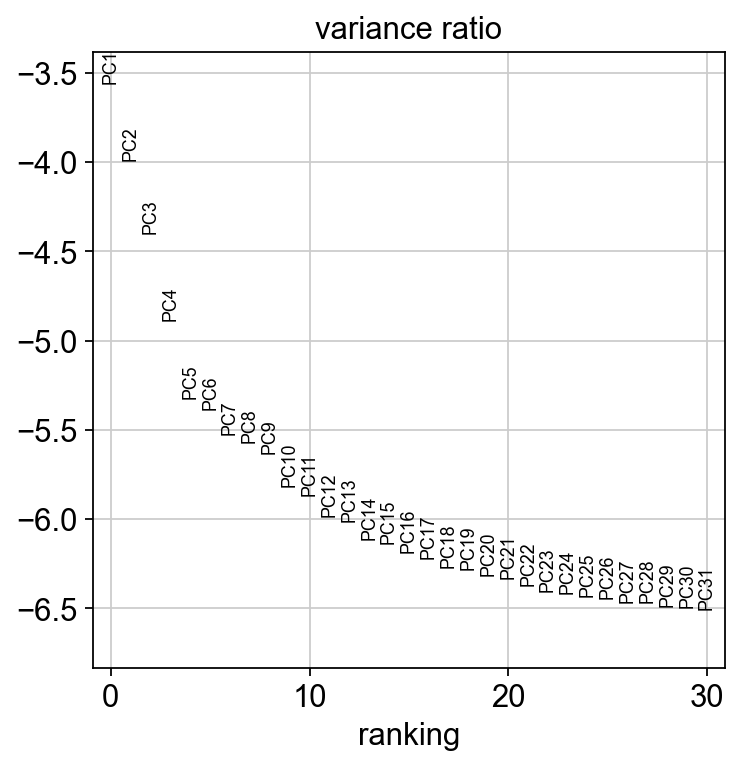

In [20]:
# PCA
sc.tl.pca(adataHiVar, svd_solver='arpack')
sc.pl.pca(adataHiVar, color=["total_counts", "n_genes", "pct_counts_mito_gene", "pct_counts_ribo_gene", "Dose Barcode", "Dose ug", "phase"], save=" - dataset info.png")
sc.pl.pca_variance_ratio(adataHiVar, log=True)

In [21]:
# UMAP
sc.pp.neighbors(adataHiVar)
sc.tl.umap(adataHiVar)

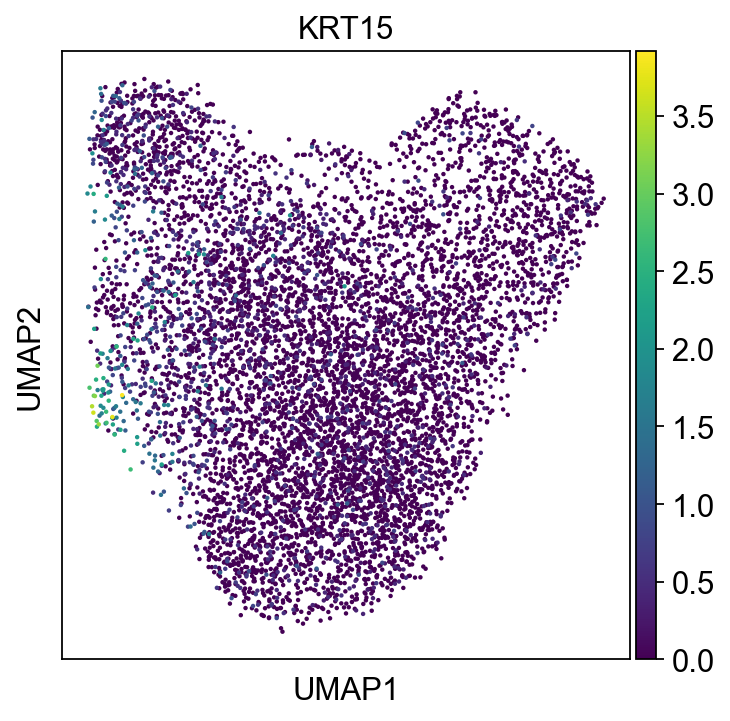

In [165]:
sc.pl.umap(adataHiVar, color=["KRT15"])

In [ ]:
# PHATE
sc.external.tl.phate(adataHiVar)

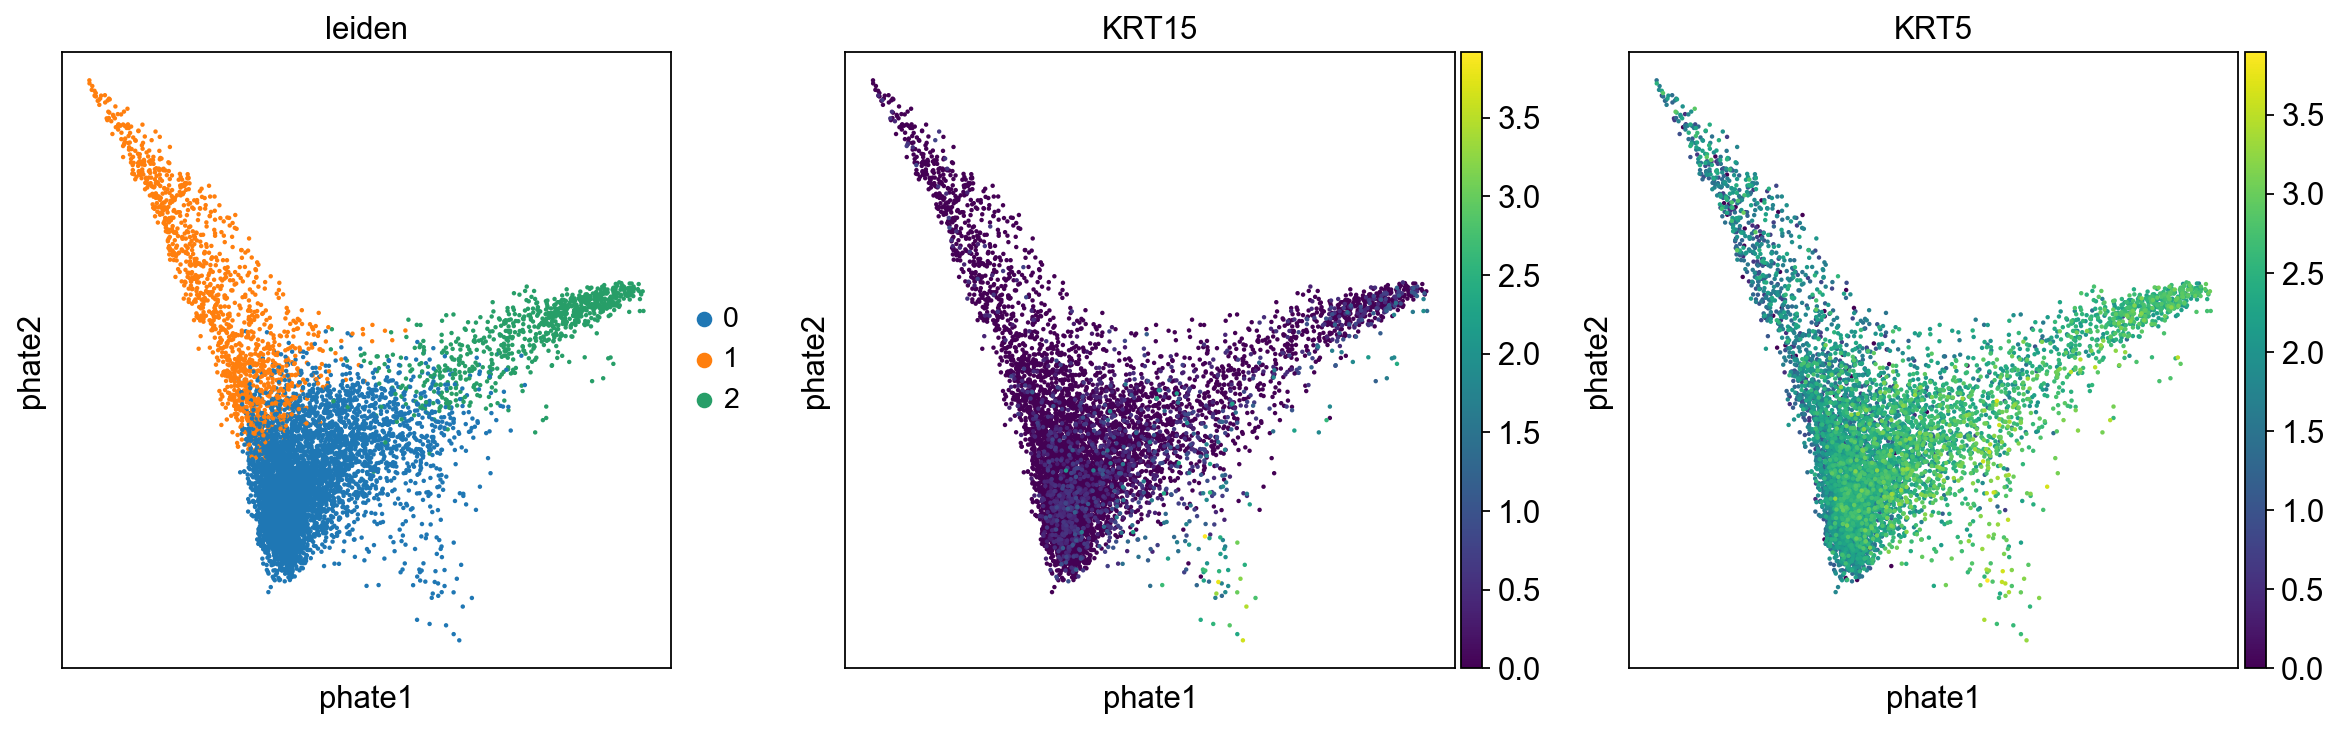

In [164]:
sc.external.pl.phate(adataHiVar, color=["KRT15", "KRT5"])

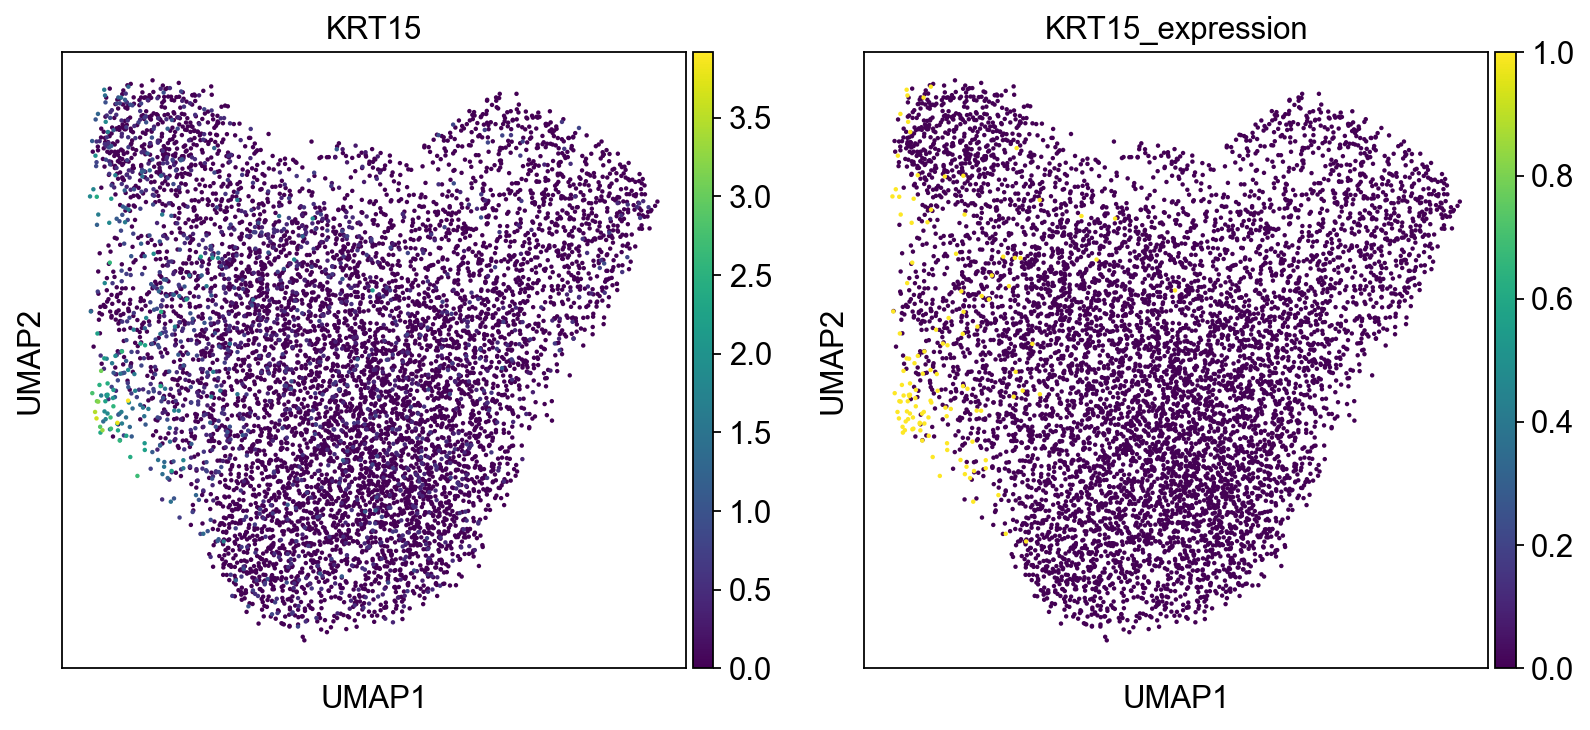

In [213]:
adataHiVar.obs['KRT15_expression'] = (adataHiVar[:, 'KRT15'].X > 3.5).astype(int)
sc.pl.umap(adataHiVar, color=["KRT15", "KRT15_expression"])

In [214]:
os.chdir(currDir)
pd.Series(adataHiVar[adataHiVar.obs['KRT15_expression'] == 1].obs_names).to_csv("KRT15_expressionHigh_cells.csv", header=False, index=False)